In [1]:
import os
import sys
import utils
import utils_ml
import logging
import traceback
import pandas as pd
import numpy as np
import sklearn as sk
import torch
import torch.nn as nn
import torch.optim as optim
import utils_model

from tqdm import tqdm
from typing import List
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from utils_model import NeuralNetwork, EarlyStopper, CustomDataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate 'x' values
num_samples = 200
x = np.linspace(0, 10, num_samples)  # Generate 100 evenly spaced values between 0 and 10

# Generate 'y' values with some random noise
# Assuming a linear relationship y = mx + c with added Gaussian noise
m = 2  # Slope of the line
c = 5  # Intercept
noise = np.random.normal(0, 1, num_samples)  # Gaussian noise with mean 0 and standard deviation 1
y = m * np.sin(x) + c + noise

# make x and y individual pandas DataFrames
x = pd.DataFrame(x, columns=['X'])
y = pd.DataFrame(y, columns=['Y'])

# # Plot the generated data
# plt.scatter(x, y, label='Data points')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Generated Data for Regression')
# plt.legend()
# plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_folds = 5
batch_size = 32
current_fold = 1
n_epochs = []

# create metrics class
metrics_class = utils_ml.Metrics(
    validation_split=0.3,
    folds=n_folds,
)

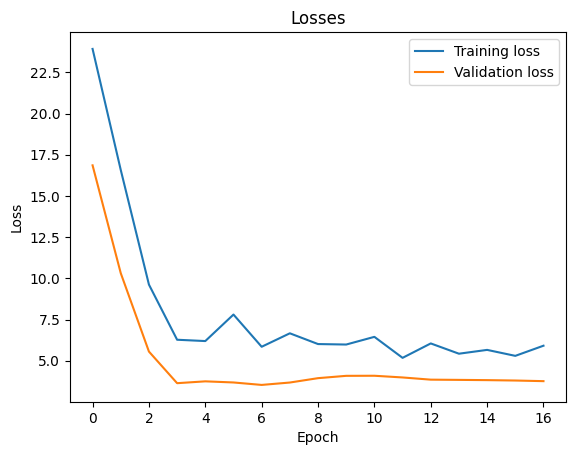

In [7]:
(y_kfold, x_kfold) = (y, x)
kfold = KFold(n_splits=n_folds, shuffle=False)
temp_metrics = pd.DataFrame(columns=metrics_class.metrics)

# make df to store model runs
model_runs = pd.DataFrame()

for train_index, test_index in kfold.split(y_kfold, x_kfold):
    x_train, x_test = x.iloc[train_index, :], x.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index, :]

    # Create validation and training sets
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.30, random_state=42
    )

    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(
        x_train.values,
        dtype=torch.float32,
    ).to(device)
    x_val_tensor = torch.tensor(
        x_val.values,
        dtype=torch.float32,
    ).to(device)
    x_test_tensor = torch.tensor(
        x_test.values,
        dtype=torch.float32,
    ).to(device)
    x_pred_tensor = torch.tensor(
        x.values,
        dtype=torch.float32,
    ).to(device)
    y_train_tensor = torch.tensor(
        y_train.values,
        dtype=torch.float32,
    ).to(device)
    y_val_tensor = torch.tensor(
        y_val.values,
        dtype=torch.float32,
    ).to(device)

    # Define PyTorch DataLoader for training
    train_dataset = CustomDataset(x_train_tensor, y_train_tensor)
    val_dataset = CustomDataset(x_val_tensor, y_val_tensor)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False
    )

    # Model Initialization
    train_losses = []
    val_losses = []
    input_dim = x_train.shape[1]
    hidden_dim = 64
    patience = 10
    model = NeuralNetwork(input_dim, hidden_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=0.001,
        weight_decay=0.1,
    )
    scheduler = ReduceLROnPlateau(
        optimizer=optimizer,
        factor=0.1,
        patience=5,
        min_lr=0,
    )

    early_stopper = EarlyStopper(patience=patience)

    # Training loop
    epochs = 700
    for epoch in range(epochs):
        # Training
        train_loss = utils_model.train_regression(
            model,
            train_loader,
            optimizer,
            criterion,
            device,
        )
        train_losses.append(train_loss)

        # Validation
        val_loss = utils_model.validate_regression(
            model,
            val_loader,
            criterion,
            device,
        )
        val_losses.append(val_loss)

        # Adjust learning rate
        scheduler.step(val_loss)

        # Early Stopping
        if early_stopper.early_stop(val_loss, model):
            n_epochs.append(epoch)
            break
    early_stopper.restore_best_weights(model)
    
    # Plot losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()

    # Prediction
    y_train_hat = model(x_train_tensor).cpu().detach().numpy()
    y_val_hat = model(x_val_tensor).cpu().detach().numpy()
    y_test_hat = model(x_test_tensor).cpu().detach().numpy()
    y_pred_hat = model(x_pred_tensor).cpu().detach().numpy()

    # Metrics Calculation
    train_points, val_points = [len(y_train)], [len(y_val)]

    train_me = np.mean(y_train_hat - y_train.values)
    val_me = np.mean(y_val_hat - y_val.values)

    train_rmse = mean_squared_error(y_train.values, y_train_hat, squared=False)
    val_rmse = mean_squared_error(y_val.values, y_val_hat, squared=False)

    train_mae = mean_absolute_error(y_train.values, y_train_hat)
    val_mae = mean_absolute_error(y_val.values, y_val_hat)

    # compile errors
    train_e = [train_me, train_rmse, train_mae]
    val_e = [val_me, val_rmse, val_mae]

    test_cols = ["Test ME", "Test RMSE", "Test MAE"]

    train_errors = np.array([train_e + val_e]).reshape((1, 6))
    errors_col = [
        "Train ME",
        "Train RMSE",
        "Train MAE",
        "Validation ME",
        "Validation RMSE",
        "Validation MAE",
    ]
    df_metrics = pd.DataFrame(
        train_errors, index=([str(current_fold)]), columns=errors_col
    )

    df_metrics["Train Points"] = train_points
    df_metrics["Validation Points"] = val_points
    df_metrics["Train r2"], _ = pearsonr(
        y_train.squeeze(),#.values.flatten(),
        y_train_hat.squeeze(),#.values.flatten(),
    )
    df_metrics["Validation r2"], _ = pearsonr(
        y_val.squeeze(),
        y_val_hat.squeeze(),
    )
    temp_metrics = pd.concat(
        objs=[
            temp_metrics,
            df_metrics,
        ]
    )

    # Model Prediction
    prediction_temp = pd.DataFrame(
        (y_pred_hat),
        columns=[current_fold],
    )

    # append prediction to model runs
    model_runs = model_runs.join(prediction_temp, how="outer")

    # increment fold
    break